# Practice: Train a Neural Network on Make Circles

In this notebook, you'll train a neural network on the **make_circles** dataset!

**What is make_circles?** It generates concentric rings (one circle inside another) that need a **non-linear boundary** to classify.

---

## How This Notebook Works

- **Instructions** explain what to do
- **TODO** sections are for you to fill in
- **Hints** are available if you get stuck
- **Solutions** are hidden - try first before looking!

---

## Step 1: Setup - Imports

First, let's import the libraries we need.

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

%matplotlib inline

print("Imports successful!")

Imports successful!


## Step 2: Copy Your Value Class

Copy the `Value` class from your summary notebook (003-summary_brief_of_micrograd.ipynb).

This is the foundation - we need it for automatic differentiation!

In [2]:
class Value:
	def __init__(self, data, _children=(), _op='', label=''):
		self.data = data
		self.grad = 0.0
		self._backward = lambda: None
		self._prev = set(_children)
		self._op = _op
		self.label = label
		
	def __repr__(self):
		return f"Value(data={self.data:.4f}, grad={self.grad:.4f})"
	
	def __add__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data + other.data, (self, other), '+')
		def _backward():
			self.grad += out.grad
			other.grad += out.grad
		out._backward = _backward
		return out
	
	def __mul__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data * other.data, (self, other), '*')
		def _backward():
			self.grad += other.data * out.grad
			other.grad += self.data * out.grad
		out._backward = _backward
		return out
	
	def __pow__(self, exponent):
		assert isinstance(exponent, (int, float)), "Only supporting int/float powers for now"
		out = Value(self.data ** exponent, (self,), f'**{exponent}')
		def _backward():
			self.grad += exponent * (self.data ** (exponent - 1)) * out.grad
		out._backward = _backward
		return out
	
	def __neg__(self):
		return self * -1
	
	def __sub__(self, other):
		return self + (-other)
	
	def __truediv__(self, other):
		return self * other**-1
	
	def __radd__(self, other):
		return self + other
	
	def __rsub__(self, other):
		return other + (-self)
	
	def __rmul__(self, other):
		return self * other

	def tanh(self):
		x = self.data
		t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
		out = Value(t, (self,), 'tanh')
		def _backward():
			self.grad += (1 - t**2) * out.grad
		out._backward = _backward
		return out
	
	def exp(self):
		x = self.data
		out = Value(math.exp(x), (self,), 'exp')
		def _backward():
			self.grad += out.data * out.grad
		out._backward = _backward
		return out
	
	def backward(self):
		topo = []
		visited = set()
		def build_topo(v):
			if v not in visited:
				visited.add(v)
				for child in v._prev:
					build_topo(child)
				topo.append(v)
		build_topo(self)
		self.grad = 1.0
		for node in reversed(topo):
			node._backward()

## Step 3: Copy Your Neural Network Classes

Copy the `Neuron`, `Layer`, and `MLP` classes from your summary notebook.

In [3]:
class Neuron:
	def __init__(self, num_inputs):
		self.w = [Value(random.uniform(-1, 1)) for _ in range(num_inputs)]
		self.b = Value(random.uniform(-1, 1))
	
	def __call__(self, x):
		activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
		return activation.tanh()
	
	def parameters(self):
		return self.w + [self.b]

class Layer:
	def __init__(self, num_inputs, num_outputs):
		self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]

	def __call__(self, x):
		outputs = [neuron(x) for neuron in self.neurons]
		return outputs[0] if len(outputs) == 1 else outputs
	
	def parameters(self):
		return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
	def __init__(self, num_inputs, layer_sizes):
		sizes = [num_inputs] + layer_sizes
		self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(layer_sizes))]

	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		return x
	
	def parameters(self):
		return [p for layer in self.layers for p in layer.parameters()]

## Step 4: Generate the Make Circles Dataset

Now let's create our training data!

**`make_circles`** creates two concentric circles (a circle inside another circle).

Parameters:
- `n_samples`: How many points to generate
- `noise`: Adds randomness to make it more realistic
- `factor`: Ratio of inner circle radius to outer circle radius (0 < factor < 1)
- `random_state`: For reproducibility

Returns:
- `X`: The 2D coordinates of each point (shape: n_samples x 2)
- `y`: The class label (0 or 1) for each point

In [4]:
X, y = make_circles(n_samples=100, noise=0.05, factor=0.5, random_state=42)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"First 5 points:\n{X[:5]}")
print(f"First 5 labels: {y[:5]}")

X shape: (100, 2)
y shape: (100,)
First 5 points:
[[-0.23609814 -0.4675    ]
 [ 0.48869037  0.24924534]
 [-0.39392915  0.32374486]
 [ 0.76420024 -0.59338464]
 [ 0.80241569 -0.74074202]]
First 5 labels: [1 1 1 0 0]


## Step 5: Convert Labels to -1 and +1

The labels from `make_circles` are 0 and 1, but our network outputs values between -1 and +1 (because of tanh).

**Hint**: `y * 2 - 1` transforms 0 -> -1 and 1 -> +1

In [5]:
y = y * 2 - 1
print(f"Unique labels: {np.unique(y)}")

Unique labels: [-1  1]


## Step 6: Visualize the Data

Let's see what our data looks like!

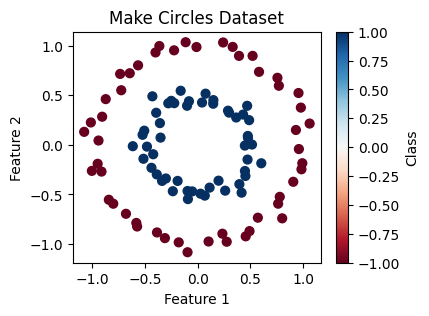

In [6]:
plt.figure(figsize=(4, 3))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', s=40)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Make Circles Dataset')
plt.colorbar(label='Class')
plt.show()

## Step 7: Create the Neural Network

**Why `MLP(2, [16, 16, 1])` for circles?**

Think about what the network needs to learn: "is this point **inside** or **outside** a circle?"

Mathematically, that's: `x² + y² < r²` → class 1, otherwise → class -1

A single neuron (perceptron) can only draw a **straight line**. It literally computes `w1*x + w2*y + b > 0`, which is a line in 2D. A circle is NOT a line, so a single neuron fails here.

**Why 2 hidden layers of 16?**
- The **first layer** (16 neurons) learns to draw 16 different lines through the data. Each neuron says "which side of my line is this point on?"
- The **second layer** (16 neurons) **combines** those lines into curves. By combining "above line A" AND "below line B" AND "right of line C"... it can approximate a circle using many small line segments (like drawing a circle with a polygon!)
- The **output layer** (1 neuron) makes the final yes/no decision

**Why not just 1 hidden layer?** With only 1 layer, the network can only combine the input features linearly before the final decision. Two layers give it the power to learn the **composition of non-linear features** — which is exactly what x² + y² requires.

**Why 16 neurons per layer?** 
- Too few (e.g., 4): not enough "lines" to approximate a smooth circle
- Too many (e.g., 64): wastes computation, and with only 100 data points, the network might memorize instead of learning the pattern (overfitting)
- 16 is a good sweet spot for this complexity level

In [7]:
random.seed(17)
model = MLP(2, [16, 16, 1])

print(f"Model created!")
print(f"Total parameters: {len(model.parameters())}")

Model created!
Total parameters: 337


## Step 8: Define the Loss Function

**Why hinge loss for circles?**

We use **hinge loss**: `max(0, 1 - y * prediction)`

Our network outputs a value between -1 and +1 (because of tanh), and our labels are -1 or +1. Hinge loss is the natural fit because:

1. **It matches our output range**: tanh gives us [-1, +1], hinge loss expects labels in {-1, +1}. They work together perfectly.

2. **It creates a "margin"**: Hinge loss isn't just happy when you get the right sign — it wants you to be CONFIDENT. It keeps pushing until `y * prediction ≥ 1`. This means:
   - Points on the inner circle → prediction should be close to +1 (not just barely positive)
   - Points on the outer circle → prediction should be close to -1 (not just barely negative)

3. **Clean gradients**: When a sample is already correctly classified with enough margin (`y * pred ≥ 1`), its loss is 0, so it contributes zero gradient. The network only updates based on samples it's still struggling with. This focuses learning where it matters.

**Why not MSE loss?** MSE (`(y - prediction)²`) would also work here but:
- MSE penalizes predictions that are "too correct" (if pred=0.9 but target=1, MSE still sees error)
- Hinge loss says "once you're confident enough, stop worrying about this sample" — more efficient

**Why L2 regularization?**
- `alpha * sum(p² for all weights)` prevents any single weight from growing too large
- Without it, the network might create extreme weights that perfectly fit the training data but fail on new points (overfitting)
- `alpha=1e-4` is a gentle nudge: "keep weights small-ish, but don't restrict learning too much"

In [8]:
def compute_loss(model, X, y, alpha=1e-4):
	# forward pass
	inputs = [list(row) for row in X]
	prediction = [model(x) for x in inputs]

	# calculate loss - Hinge loss
	losses = []
	for yi,pred in zip(y,prediction):
		margin = 1 + (-yi) * pred
		if margin.data > 0:
			losses.append(margin)
		else:
			losses.append(Value(0))
	avg_data_loss = sum(losses) * (1.0 / len(losses))
	reg_loss = alpha * sum(p*p for p in model.parameters())

	total_loss = avg_data_loss + reg_loss

	accuracy = sum(1 for yi, pred in zip(y, prediction) if (yi > 0) == (pred.data > 0)) / len(y)

	return total_loss, accuracy

## Step 9: The Training Loop!

**Why these hyperparameters?**

**`learning_rate = 1.0`** — This might seem high, but remember:
- Hinge loss gradients are naturally bounded (either 0 or a fraction of the data contributes)
- We're averaging over all 100 samples, which smooths out the gradient
- With tanh activation, gradient magnitudes are already limited by the derivative `(1 - tanh²)` which maxes out at 1.0
- If lr were 0.01 (like before), it would barely move each step and need thousands of iterations

**`num_iteration = 100`** — Circles have a relatively simple boundary (just one curve), so:
- By ~50 iterations, the network usually finds the approximate shape
- By ~100, it's refined the boundary nicely
- More iterations give diminishing returns — the loss flattens out

**`n_samples = 100`** — Why not 500?
- Micrograd processes each sample one-by-one in pure Python (no GPU, no vectorization)
- 500 samples = 5x slower per iteration
- 100 samples is enough to define a circle — think about it, you only need ~20 points to draw a circle, 100 gives plenty of coverage

In [9]:
learning_rate = 1.0
num_iteration = 100

print("Training...")
print("="*50)

for iteration in range(num_iteration):
    
    loss, accuracy = compute_loss(model, X, y)
    
    for p in model.parameters():
        p.grad = 0.0
        
    loss.backward()
    
    for p in model.parameters():
        p.data += -learning_rate * p.grad
    
    if iteration % 10 == 0:
        print(f"Iteration {iteration:3d} | Loss: {loss.data:.4f} | Accuracy: {accuracy*100:.1f}%")
        

print("="*50)
print(f"Final - Loss: {loss.data:.4f} | Accuracy: {accuracy*100:.1f}%")

Training...
Iteration   0 | Loss: 1.0666 | Accuracy: 42.0%
Iteration  10 | Loss: 0.5515 | Accuracy: 78.0%
Iteration  20 | Loss: 0.5707 | Accuracy: 75.0%
Iteration  30 | Loss: 0.4117 | Accuracy: 83.0%
Iteration  40 | Loss: 0.2714 | Accuracy: 88.0%
Iteration  50 | Loss: 0.1798 | Accuracy: 93.0%
Iteration  60 | Loss: 0.1440 | Accuracy: 95.0%
Iteration  70 | Loss: 0.1075 | Accuracy: 96.0%
Iteration  80 | Loss: 0.2308 | Accuracy: 91.0%
Iteration  90 | Loss: 0.0308 | Accuracy: 100.0%
Final - Loss: 0.0259 | Accuracy: 100.0%


## Step 10: Visualize the Decision Boundary!

This is the coolest part - let's see what the network learned!

We'll:
1. Create a grid of points covering the plot area
2. Get the network's prediction for each point
3. Color the background based on predictions
4. Overlay the original data points

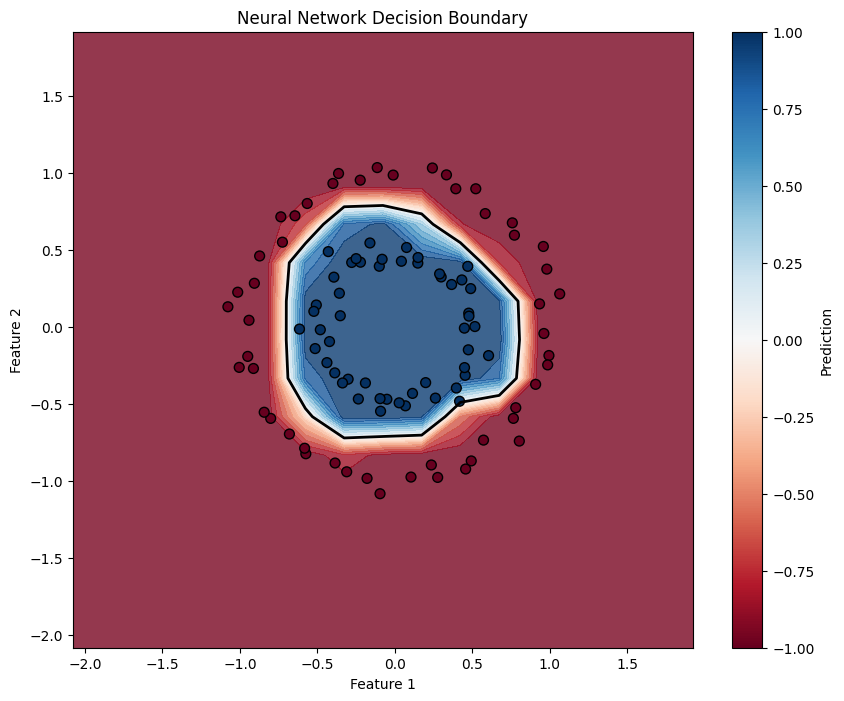

In [10]:
def plot_decision_boundary(model, X, y):
	h = 0.25
	x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
	y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
	xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
						 np.arange(y_min, y_max, h))
	
	mesh_points = np.c_[xx.ravel(), yy.ravel()]
	Z = []
	for point in mesh_points:
		pred = model(list(point))
		Z.append(pred.data)
	Z = np.array(Z).reshape(xx.shape)
	
	plt.figure(figsize=(10, 8))
	plt.contourf(xx, yy, Z, levels=np.linspace(-1, 1, 20), cmap='RdBu', alpha=0.8)
	plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
	plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolors='black', s=50)
	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.title('Neural Network Decision Boundary')
	plt.colorbar(label='Prediction')
	plt.show()

plot_decision_boundary(model, X, y)

---

## Congratulations!

You've just trained a neural network to classify the make_circles dataset!

**What you accomplished:**
- Used the make_circles dataset from scikit-learn
- Built an MLP classifier from scratch
- Trained the network with gradient descent
- Visualized the learned decision boundary on concentric circles

---